In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-crime/test.csv.zip
/kaggle/input/sf-crime/sampleSubmission.csv.zip
/kaggle/input/sf-crime/train.csv.zip


In [2]:
train = pd.read_csv("/kaggle/input/sf-crime/train.csv.zip")
test = pd.read_csv("/kaggle/input/sf-crime/test.csv.zip")

In [3]:
train.shape

(878049, 9)

In [4]:
#No missing values in train set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          884262 non-null  int64  
 1   Dates       884262 non-null  object 
 2   DayOfWeek   884262 non-null  object 
 3   PdDistrict  884262 non-null  object 
 4   Address     884262 non-null  object 
 5   X           884262 non-null  float64
 6   Y           884262 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


In [6]:
#dropping Resolution and Descript columns from train set as they are not present in test set and hence
#cannot be used for analysis
train.drop(['Descript','Resolution'], axis = 1,inplace=True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   DayOfWeek   878049 non-null  object 
 3   PdDistrict  878049 non-null  object 
 4   Address     878049 non-null  object 
 5   X           878049 non-null  float64
 6   Y           878049 non-null  float64
dtypes: float64(2), object(5)
memory usage: 46.9+ MB


In [8]:
#check and remove duplicate values if any
train.duplicated().sum()

65459

In [9]:
train.drop_duplicates(inplace=True)

In [10]:
BBox = train.X.min(),train.X.max(),train.Y.min(),train.Y.max()

In [11]:
BBox

(-122.51364206429, -120.5, 37.7078790224135, 90.0)

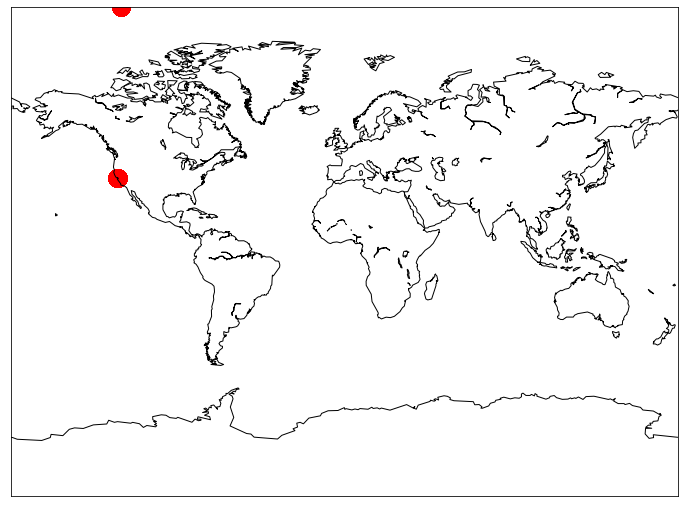

In [12]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,9))

m = Basemap(projection='mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')

m.drawcoastlines()

m.scatter(train['X'].tolist(),train['Y'].tolist(),latlon=True,s=300,c='red')

In [13]:
import seaborn as sns


In [14]:
count = train['Category'].value_counts()

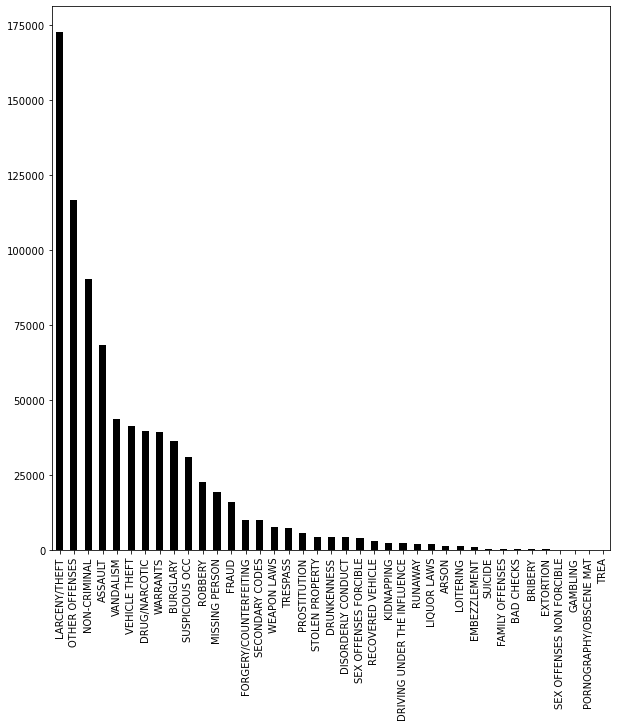

In [15]:
#Maximum crimes belong to category : Larceny/Theft
count.plot(kind='bar', figsize = (10,10) , color = 'black')

In [16]:
time=[]
for i in train['Dates']:
    x=i.split()
    time.append(x[1])
time=pd.Series(time)    

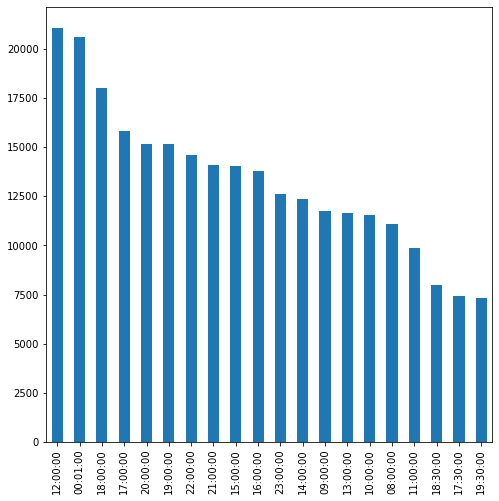

In [17]:
#top 20 times when the occurence of crime was the highest
#the plot suggests the maximum crimes occur at 12 noon and 12 midnight
time.value_counts()[:20].plot(kind='bar',figsize=(8,8))

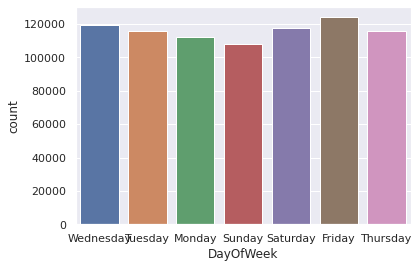

In [18]:
#Crime frequency doesn't differ alot among different days of the week but it is the maximum on friday
sns.set()
sns.countplot(x=train['DayOfWeek'],data=train)

In [19]:
def transformDataset(dataset):
    dataset['Dates'] = pd.to_datetime(dataset['Dates'])
    
    dataset['Date'] = dataset['Dates'].dt.date
    
    dataset['n_days'] = (dataset['Date'] - dataset['Date'].min()).apply(lambda x: x.days)
    
    dataset['Year'] = dataset['Dates'].dt.year
    dataset['DayOfWeek'] = dataset['Dates'].dt.dayofweek # OVERWRITE
    dataset['WeekOfYear'] = dataset['Dates'].dt.weekofyear
    dataset['Month'] = dataset['Dates'].dt.month
    
    dataset['Hour'] = dataset['Dates'].dt.hour
    
    dataset['Block'] = dataset['Address'].str.contains('block', case=False)
    dataset['Block'] = dataset['Block'].map(lambda x: 1 if  x == True else 0)

    
    dataset = dataset.drop('Dates', 1)
    dataset = dataset.drop('Date', 1)
    dataset = dataset.drop('Address', 1)
    
    dataset = pd.get_dummies(data=dataset, columns=[ 'PdDistrict'], drop_first = True)
    return dataset

In [20]:
train = transformDataset(train)
test = transformDataset(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [21]:
X = train.drop("Category",axis=1)
y = train["Category"]

In [22]:
Y = pd.get_dummies(y)

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)
    
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(609442, 18) (609442, 39)
(203148, 18) (203148, 39)


In [24]:
from keras.models import Sequential
from keras.layers import Dense,Activation

In [25]:
model = Sequential()

model.add(Dense(100,input_shape=(18,)))
model.add(Activation('relu'))

model.add(Dense(80))
model.add(Activation("relu"))

model.add(Dense(60))
model.add(Activation("relu"))

model.add(Dense(39))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1900      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
activation_1 (Activation)    (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
activation_2 (Activation)    (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 39)                2

In [26]:
model.compile(optimizer='adam',
             loss = "categorical_crossentropy",
             metrics=['accuracy'])


In [27]:
model.fit(X,Y,
         batch_size=256,
         epochs = 10,
         verbose = 2,
         validation_data=(X_train,Y_train))

Epoch 1/10
3175/3175 - 10s - loss: 3.8624 - accuracy: 0.1852 - val_loss: 2.6844 - val_accuracy: 0.2180
Epoch 2/10
3175/3175 - 10s - loss: 2.6597 - accuracy: 0.2170 - val_loss: 2.6841 - val_accuracy: 0.2175
Epoch 3/10
3175/3175 - 12s - loss: 2.6260 - accuracy: 0.2228 - val_loss: 2.6439 - val_accuracy: 0.2128
Epoch 4/10
3175/3175 - 12s - loss: 2.6051 - accuracy: 0.2262 - val_loss: 2.5998 - val_accuracy: 0.2198
Epoch 5/10
3175/3175 - 9s - loss: 2.5895 - accuracy: 0.2289 - val_loss: 2.5702 - val_accuracy: 0.2320
Epoch 6/10
3175/3175 - 9s - loss: 2.5789 - accuracy: 0.2305 - val_loss: 2.5666 - val_accuracy: 0.2325
Epoch 7/10
3175/3175 - 10s - loss: 2.5714 - accuracy: 0.2326 - val_loss: 2.5726 - val_accuracy: 0.2346
Epoch 8/10
3175/3175 - 10s - loss: 2.5670 - accuracy: 0.2332 - val_loss: 2.5842 - val_accuracy: 0.2299
Epoch 9/10
3175/3175 - 10s - loss: 2.5635 - accuracy: 0.2337 - val_loss: 2.5662 - val_accuracy: 0.2334
Epoch 10/10
3175/3175 - 10s - loss: 2.5594 - accuracy: 0.2340 - val_loss: 2

In [28]:
preds_vals = model.predict(test.drop("Id",axis=1))
preds = pd.DataFrame(data=preds_vals,columns=Y.columns)
preds

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.002691,0.115082,0.000078,0.000838,0.045949,0.002044,0.001475,0.027865,0.003979,0.000220,...,0.000178,0.006398,0.000289,0.039085,2.065927e-06,0.004245,0.093040,0.085450,0.037414,0.016950
1,0.001966,0.084562,0.000014,0.000426,0.002700,0.001995,0.003677,0.034724,0.004888,0.000025,...,0.000076,0.005683,0.000032,0.026596,1.963344e-07,0.000755,0.074874,0.102674,0.046982,0.016963
2,0.001971,0.102529,0.000089,0.000528,0.051623,0.001926,0.001250,0.027499,0.004237,0.000247,...,0.000113,0.006532,0.000283,0.033511,1.960370e-06,0.004575,0.088343,0.073734,0.036687,0.011392
3,0.002234,0.110609,0.000034,0.000487,0.040858,0.000929,0.001075,0.020946,0.002392,0.000113,...,0.000100,0.005119,0.000191,0.038256,3.875634e-07,0.002761,0.108412,0.122097,0.028656,0.015741
4,0.002234,0.110609,0.000034,0.000487,0.040858,0.000929,0.001075,0.020946,0.002392,0.000113,...,0.000100,0.005119,0.000191,0.038256,3.875634e-07,0.002761,0.108412,0.122097,0.028656,0.015741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,0.007636,0.127622,0.002335,0.000941,0.035741,0.027288,0.004793,0.055727,0.011226,0.004416,...,0.000878,0.005849,0.001537,0.041393,1.234776e-06,0.019020,0.050875,0.035806,0.059155,0.012814
884258,0.006124,0.108175,0.002283,0.000794,0.029247,0.018379,0.005503,0.040446,0.009903,0.003693,...,0.000653,0.008267,0.001099,0.045618,8.326831e-06,0.014082,0.049057,0.035053,0.056554,0.010960
884259,0.008708,0.128205,0.001202,0.000722,0.047656,0.009239,0.004747,0.022917,0.006166,0.002143,...,0.000777,0.005653,0.001471,0.043960,1.473533e-06,0.009578,0.080859,0.087327,0.036903,0.012904
884260,0.010591,0.123129,0.002432,0.001325,0.044365,0.020145,0.007509,0.030476,0.010419,0.003923,...,0.001374,0.007052,0.002195,0.042506,7.479477e-06,0.014211,0.065547,0.055539,0.044671,0.013510


In [29]:
new_df = pd.DataFrame(np.where(preds.T == preds.T.max(), 1, 0),index=preds.columns).T
new_df

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
new_df['Id'] = test["Id"]

In [31]:
cols = list(new_df.columns)
cols = [cols[-1]] + cols[:-1]
new_df = new_df[cols]

In [32]:
new_df

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,884257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884258,884258,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884259,884259,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884260,884260,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
new_df.to_csv('../working/submission.csv', index=False)